# Statistical Analysis and Data Processing about NHS database


## Introduction

The project data has been provided by Lancashire Teaching Hospitals. They have setup a sandbox Kubernetes computing cluster on AZURE for providing data. This paper have used Trust Catchment, GIS Data and Vaccination Data. The main goal of the project as to predict the number of Covid cases to every NHS trust based in Covid related fac- tors. Namely, the number of cases in neighbouring trusts.

## Data reconcialiation

The data are combined into a single dataframe with four files.

In [5]:
# Reference libraries
from extract import Extractor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest

# Get four data tables
Worksheet = "2021 Trust Catchment Populations Worksheet.xlsx"
Ethnicity = "2021 Trust Catchment Populations_Supplementary Trust Ethnicity.xlsx"
IMD = "2021 Trust Catchment Populations_Supplementary Trust IMD Scores.xlsx"
lookup = "2021 Trust Catchment Populations_Supplementary Trust Area lookup.xlsx"

# Reference extractor
e = Extractor("../1_Original_data")
df_Worksheet = e.readExcel(Worksheet) # read the database
df_Ethnicity = e.readExcel(Ethnicity)
df_IMD = e.readExcel(IMD)
df_lookup = e.readExcel(lookup)

# Calculate the probability of infection
df_Worksheet['infect_pro'] = df_Worksheet['PatientsAdmitted'] / df_Worksheet['Catchment']
# Calculate the total population of each trust
df_Ethnicity['total_population'] = df_Ethnicity['White'] + df_Ethnicity['Black'] + df_Ethnicity['Asian']+ \
                               df_Ethnicity['Mixed'] + df_Ethnicity['Other']

# merge tables
df_merge = pd.merge(df_Ethnicity,df_IMD, left_on = ['TrustName', 'TrustCode', 'AdmissionType', 'CatchmentYear'],\
                    right_on = ['Trust Name', 'Trust Code', 'Admission Type', 'Catchment Year'],\
                    how = 'outer')
df_merge['TrustName'].fillna(df_merge['Trust Name'], inplace=True)
df_merge['TrustCode'].fillna(df_merge['Trust Code'], inplace=True)
df_merge['AdmissionType'].fillna(df_merge['Admission Type'], inplace=True)
df_merge['CatchmentYear'].fillna(df_merge['Catchment Year'], inplace=True)
del df_merge['Trust Name']
del df_merge['Trust Code']
del df_merge['Admission Type']
del df_merge['Catchment Year']

df_merge_1 = pd.merge(df_merge,df_lookup, on = ['TrustName', 'TrustCode'],how = 'outer')
set(df_merge_1['TrustCode'].isnull())

df_merge_2 = pd.merge(df_merge_1,df_Worksheet, \
                      on = ['TrustName', 'TrustCode','CatchmentYear', 'AdmissionType','TrustType'],\
                      how = 'outer')
set(df_merge_2['TrustName'].isnull())

# The final summary table
df_total = df_merge_2.drop_duplicates()

In [6]:
df_Worksheet.columns 

Index(['CatchmentYear', 'AdmissionType', 'TrustCode', 'TrustName', 'TrustType',
       'Sex', 'Sex_Desc', 'Age', 'Catchment', 'LCI', 'UCI', 'Variance',
       'PatientsAdmitted', 'infect_pro'],
      dtype='object')

In [7]:
df_Ethnicity.columns

Index(['TrustName', 'TrustCode', 'AdmissionType', 'CatchmentYear', 'White',
       'Black', 'Asian', 'Mixed', 'Other', 'total_population'],
      dtype='object')

In [8]:
df_IMD.columns

Index(['Trust Name', 'Trust Code', 'Admission Type', 'Catchment Year',
       'IMD Score', 'Rank (1 is most deprived)'],
      dtype='object')

In [9]:
df_lookup.columns

Index(['TrustCode', 'TrustName', 'TrustType', 'LTLA21CD', 'LTLA21NM',
       'UTLA21CD', 'UTLA21NM', 'CCG20CD', 'CCG20NM', 'NHSRegionsLocalCode',
       'NHSRegionsLocalName', 'STP20CD', 'STP20NM', 'PHEC15CD', 'PHEC15NM'],
      dtype='object')

## Exploratory Data Analysis

### The demographic composition of 140 trusts is analysed here.

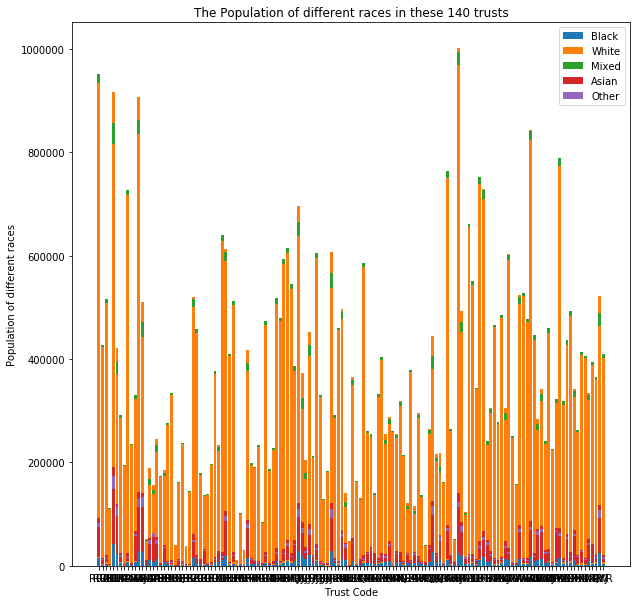

In [10]:
# with the largest number of whites and the smallest number of blacks and others.
df_0 = df_Ethnicity[(df_Ethnicity['AdmissionType']== 'All Admissions')&(df_Ethnicity['CatchmentYear']== 2019)]
list_0 = ['Black','White','Mixed','Asian','Other']
plt.figure(figsize = (10,10))
for i in range(len(list_0)):
    if i == 0:
        plt.bar(df_0['TrustCode'],df_0[list_0[i]],label = list_0[i])
    else:
        plt.bar(df_0['TrustCode'],df_0[list_0[i]],bottom = df_0[list_0[i-1]],label = list_0[i])
plt.legend(loc = 1)
plt.xlabel('Trust Code')
plt.ylabel('Population of different races')
plt.title('The Population of different races in these 140 trusts')
plt.show()

### The probability of contracting COVID-19 in trust facilities from different geographical locations.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0.5, 0.98, 'The probability of contracting COVID-19 in trust facilities from different geographical locations')

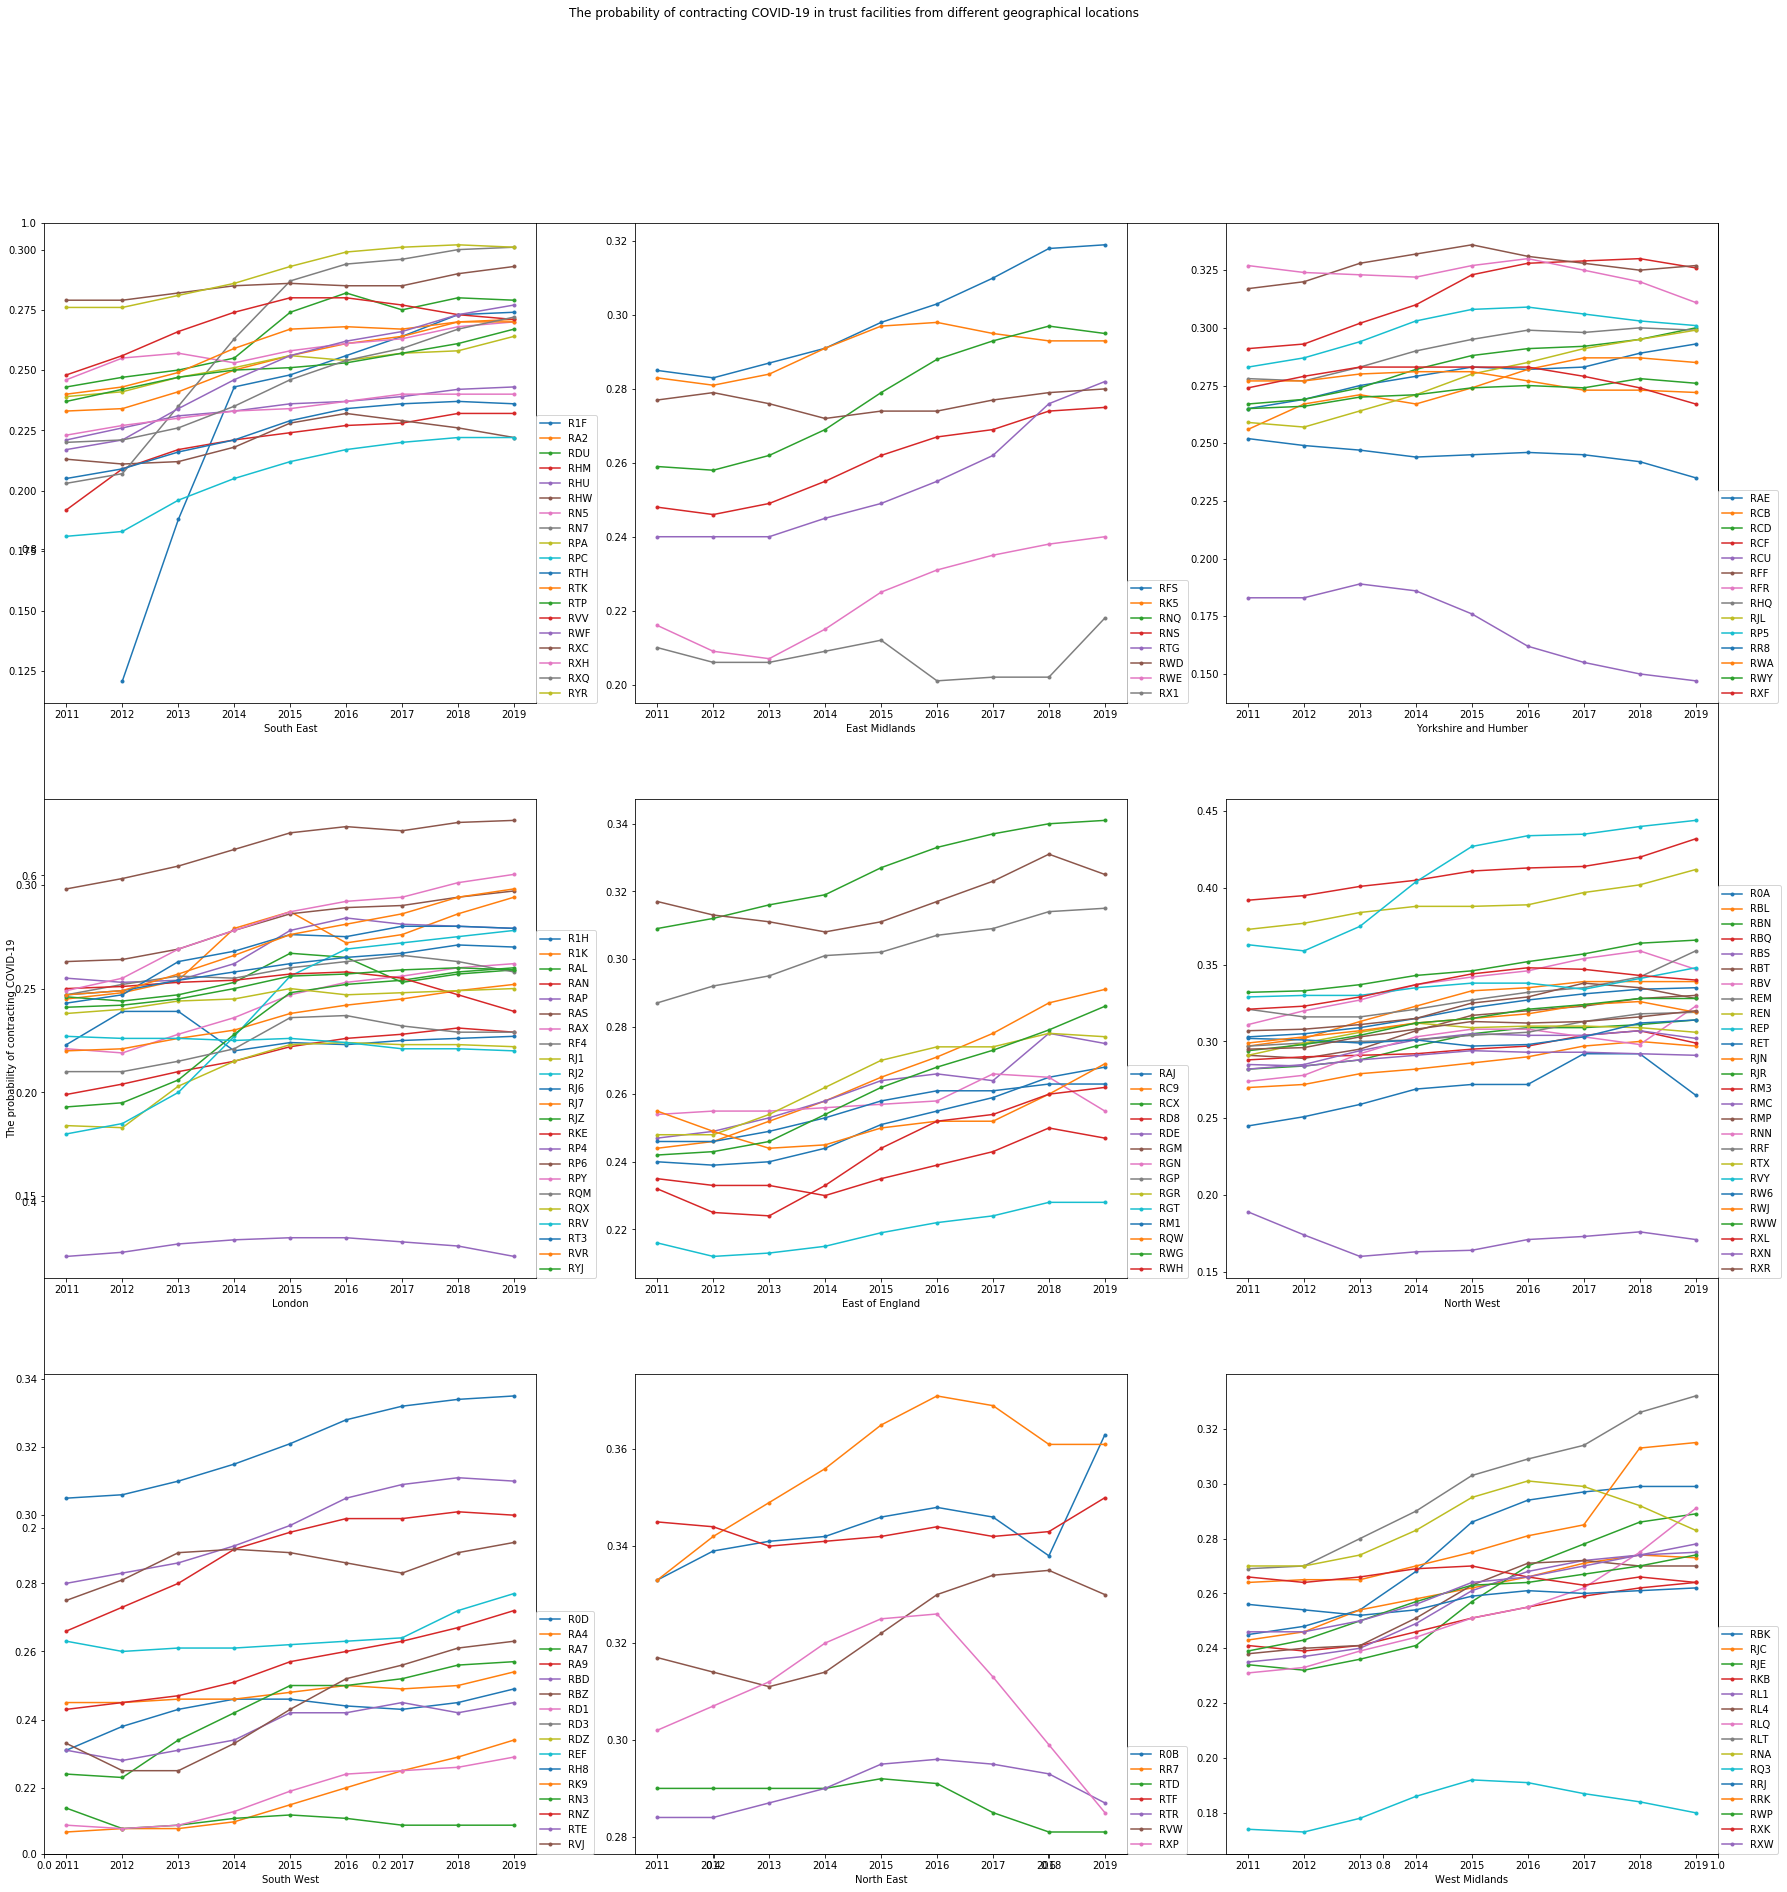

In [11]:
fig = plt.figure(figsize = (30,30))
plt.ylabel("The probability of contracting COVID-19")  
for area,num in zip(list(set(df_lookup['PHEC15NM'])),range(1,10)):
    sub_plot = fig.add_subplot(3,3,num)
    df_area = df_lookup[df_lookup['PHEC15NM'] == area]['TrustCode']
    for i in df_area:
        list_1 = []
        for n in range(2011,2020):
            df_0 = df_Worksheet[(df_Worksheet['CatchmentYear']== n)&(df_Worksheet['TrustCode']== i)]
            Catchment = df_0['Catchment'].sum()
            Patients = df_0['PatientsAdmitted'].sum()
            trust_pro = Patients/Catchment
            list_1.append((area,i,n,round(trust_pro,3)))
        df_1 = pd.DataFrame(list_1, columns=['Location','TrustCode', 'CatchmentYear','trust_pro']) 
        df_1 = df_1.sort_values(by=['CatchmentYear'])
        sub_plot.plot(df_1["CatchmentYear"],df_1["trust_pro"],'.-',label = i)
        # plt.legend(bbox_to_anchor = (1, 0), loc = 3, borderaxespad = 0)
    
    # Add the names of the horizontal and vertical axes to figures
    sub_plot.legend(bbox_to_anchor = (1, 0), loc = 3, borderaxespad = 0)
    sub_plot.set_xlabel(str(area))
    # sub_plot.set_ylabel('The probability of contracting COVID-19')
fig.suptitle('The probability of contracting COVID-19 in trust facilities from different geographical locations')



### Slice up 2019 according to the previous heading.

[('R1H', 0.227, 'London'), ('RBD', 0.31, 'South West'), ('RN3', 0.257, 'South West'), ('R0A', 0.265, 'North West'), ('RCU', 0.147, 'Yorkshire and Humber'), ('RVJ', 0.263, 'South West')]


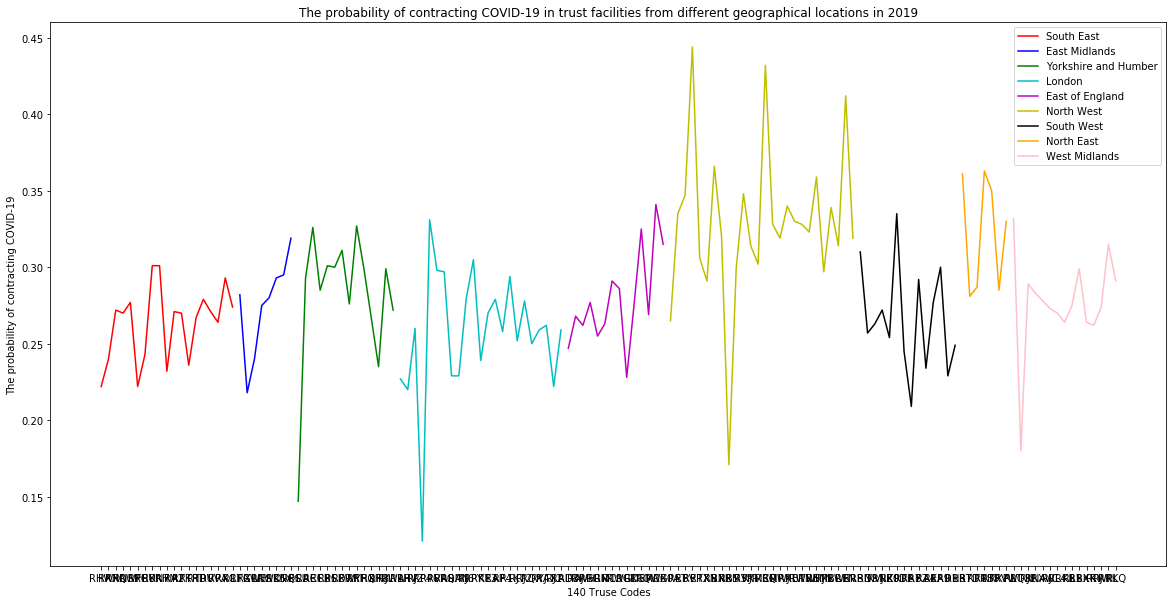

In [12]:
list_0 = []
for i in list(set(df_Worksheet['TrustCode'])):
    Catchment = df_total[(df_total['TrustCode'] == i)&(df_total['CatchmentYear'] == 2019)]['Catchment'].sum()
    Patients = df_total[(df_total['TrustCode'] == i)&(df_total['CatchmentYear'] == 2019)]['PatientsAdmitted'].sum()
    trust_pro = Patients/Catchment
    location = df_lookup[df_lookup['TrustCode'] == i]['PHEC15NM'].values[0]
    list_0.append((i, round(trust_pro,3), location))
print(list_0[:6])
    
df_1 = pd.DataFrame(list_0, columns=['TrustCode', 'trust_pro','location']) 

# draw a picture 
plt.figure(figsize = (20,10))
# plt.figure(figsize = (100,10))
color = ['r','b','g','c','m','y','k','orange','pink']
for i,col in zip(list(set(df_1['location'])),color):
    y = df_1[df_1['location'] == i]['trust_pro']
    x = df_1[df_1['location'] == i]['TrustCode']
    plt.plot(x,y,col,label = i)
plt.legend(loc = 1)
plt.xlabel('140 Truse Codes')
plt.ylabel('The probability of contracting COVID-19')
plt.title('The probability of contracting COVID-19 in trust facilities from different geographical locations in 2019')
plt.show()
# It can be seen that only three trust institutions have an infection rate of more than 40%, 
# Regionally, all three trusts are located in the northwest, 
# which suggests that the probability of infection may be related to the region.
# Four institutions maintain an infection rate of less than 20%, 
# And most trust institutions are in the infection range of 20% ~ 40%


### The probability of contracting COVID-19 in men and women at different ages from 2011 to 2019

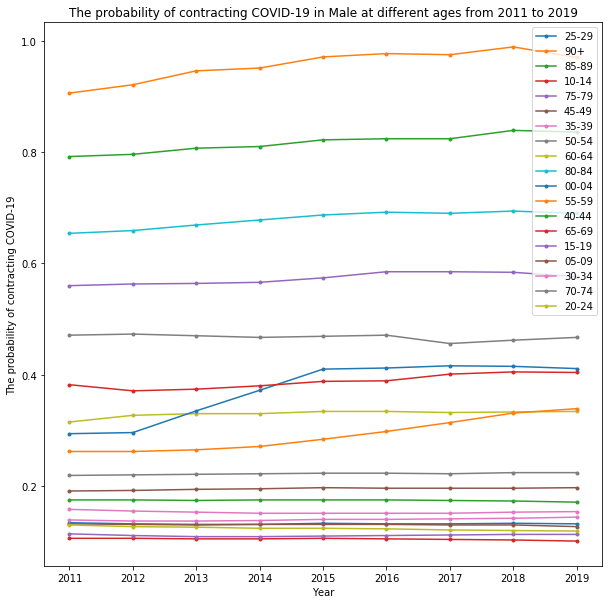

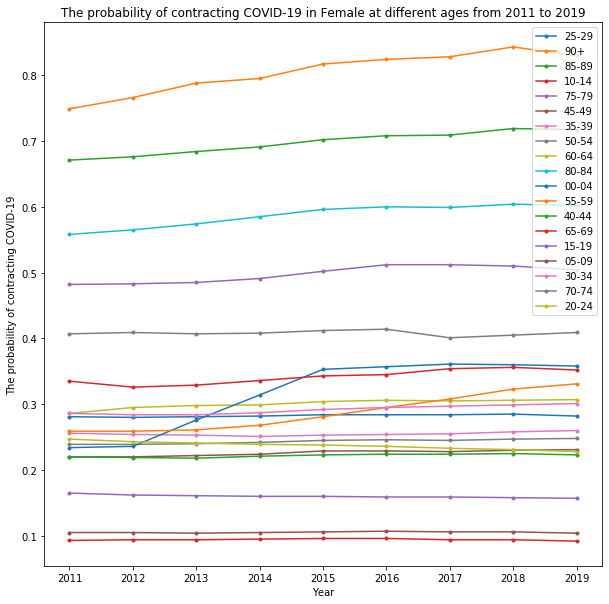

In [13]:
# Here we're going to compare age, sex and year how does that affect infection rates.
df_0 = df_Worksheet[['Sex_Desc','Age','Catchment','PatientsAdmitted','CatchmentYear']]
for sex in ['Male','Female']:
    plt.figure(figsize = (10,10))
    for age in list(set(df_0['Age'])):
        list_0 = []
        for i in list(set(df_0['CatchmentYear'])):
            Patients  = df_0[(df_0['Sex_Desc']==sex)&(df_0['CatchmentYear']==i)&(df_0['Age']==age)]['PatientsAdmitted'].sum()
            Catchment = df_0[(df_0['Sex_Desc']==sex)&(df_0['CatchmentYear']==i)&(df_0['Age']==age)]['Catchment'].sum()
            Male_15_pro = Patients / Catchment
            list_0.append((sex,age,i,(round(Male_15_pro,3))))
        df_1 = pd.DataFrame(list_0, columns=['Sex','Age','CatchmentYear','infect_pro']) 
        df_1 = df_1.sort_values(by=['CatchmentYear'])
        plt.plot(df_1["CatchmentYear"],df_1["infect_pro"],'.-',label = age)
    plt.legend(loc = 1)
    plt.xlabel('Year')
    plt.ylabel('The probability of contracting COVID-19')
    plt.title('The probability of contracting COVID-19 in ' + str(sex) + ' at different ages from 2011 to 2019')
plt.show()

# As can be seen from the two graphs, except for the age group 0-4 years old, 
# other age groups have little change with the years.



### The probability of contracting COVID-19 in women and men at different ages in 2019

[(0.282, '25-29', 'Female'), (0.829, '90+', 'Female'), (0.717, '85-89', 'Female'), (0.092, '10-14', 'Female'), (0.504, '75-79', 'Female'), (0.231, '45-49', 'Female'), (0.26, '35-39', 'Female'), (0.248, '50-54', 'Female'), (0.307, '60-64', 'Female'), (0.602, '80-84', 'Female'), (0.358, '00-04', 'Female'), (0.331, '55-59', 'Female'), (0.223, '40-44', 'Female'), (0.352, '65-69', 'Female'), (0.157, '15-19', 'Female'), (0.104, '05-09', 'Female'), (0.301, '30-34', 'Female'), (0.409, '70-74', 'Female'), (0.228, '20-24', 'Female'), (0.132, '25-29', 'Male'), (0.97, '90+', 'Male'), (0.836, '85-89', 'Male'), (0.101, '10-14', 'Male'), (0.576, '75-79', 'Male'), (0.197, '45-49', 'Male'), (0.154, '35-39', 'Male'), (0.224, '50-54', 'Male'), (0.334, '60-64', 'Male'), (0.69, '80-84', 'Male'), (0.411, '00-04', 'Male'), (0.339, '55-59', 'Male'), (0.171, '40-44', 'Male'), (0.404, '65-69', 'Male'), (0.113, '15-19', 'Male'), (0.127, '05-09', 'Male'), (0.144, '30-34', 'Male'), (0.467, '70-74', 'Male'), (0.119

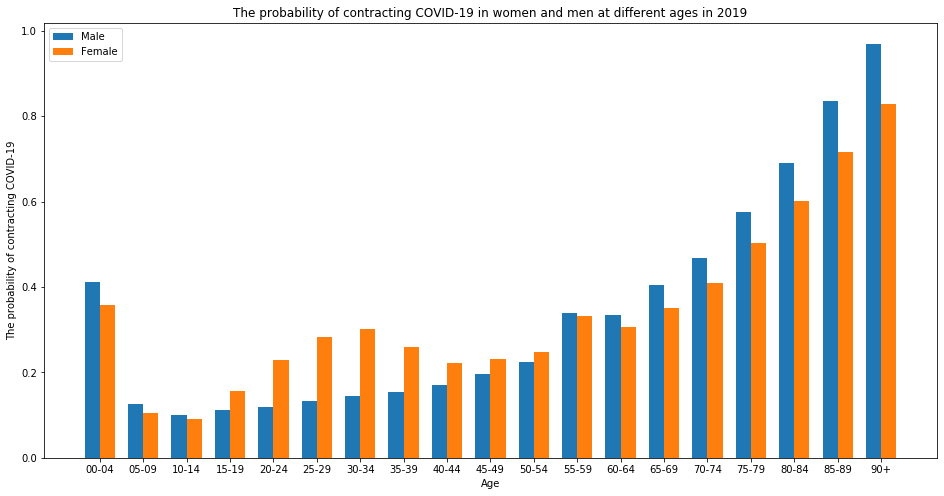

In [15]:
# We can see that there is a big difference in the incidence of disease at different ages and sex, 
# so it has to do with age and sex.  
df_0 = df_Worksheet[['Sex_Desc','Age','Catchment','PatientsAdmitted','CatchmentYear']]
list_0 = []
for n in list(set(df_0['Sex_Desc'])):
    for i in list(set(df_0['Age'])):
        Patients  = df_0[(df_0['Sex_Desc']== n)&(df_0['CatchmentYear']==2019)&(df_0['Age']==i)]['PatientsAdmitted'].sum()
        Catchment = df_0[(df_0['Sex_Desc']== n)&(df_0['CatchmentYear']==2019)&(df_0['Age']==i)]['Catchment'].sum()
        pro = Patients / Catchment
        list_0.append((round(pro,3),i,n))
        
print(list_0)
 
# Convert the list to a Dataframe and sort it by age
df_1 = pd.DataFrame(list_0, columns=['Male_2019_pro', 'Age','Sex_Desc']) 
df_1 = df_1.sort_values(by=['Age'])
print(df_1.head())

# draw a picture 
plt.figure(figsize = (16,8))
y = df_1[df_1['Sex_Desc'] == 'Male']['Male_2019_pro']
y1 = df_1[df_1['Sex_Desc'] == 'Female']['Male_2019_pro']
labels = df_1[df_1['Sex_Desc'] == 'Male']['Age']
x = np.arange(len(labels))
width = 0.35
plt.bar(x-width/2, y, width, label='Male')
plt.bar(x+width/2, y1, width, label='Female')
plt.legend()
plt.xticks(x, labels)
plt.xlabel('Age')
plt.ylabel('The probability of contracting COVID-19')
plt.title('The probability of contracting COVID-19 in women and men at different ages in 2019')
plt.show()




### Isolated forests are used to remove outliers and null values

In [16]:
df_map = df_total[['TrustCode','AdmissionType','CatchmentYear', 'White','Black', 'Asian', 'Mixed', 'Other', \
                   'total_population', 'IMD Score','TrustType','LTLA21NM','UTLA21NM','CCG20NM','NHSRegionsLocalName',\
                   'STP20NM','PHEC15NM','Sex','Age','Catchment','LCI','UCI','Variance','PatientsAdmitted','infect_pro']]

# Classify string letters and map them to digital data
def class_mapping(colums_name):
    class_mapping = {label: idx for idx, label in enumerate(np.unique(df_map[colums_name].astype(str)))}
    df_map[colums_name] = df_map[colums_name].map(class_mapping)

list_0 = ['TrustCode','AdmissionType','TrustType','LTLA21NM','UTLA21NM','CCG20NM','NHSRegionsLocalName','STP20NM','PHEC15NM','Age']
for i in list_0:
    class_mapping(i)

df_map.shape  # (140806, 25)
df_delnull = df_map.dropna() # shape = (112712, 25)


# Isolated forests, set the number of outliers at 1%
def ILF(np_1):
    clf = IsolationForest(max_samples = "auto", contamination= 0.01)
    preds = clf.fit_predict(np_1) # The outlier is labeled "-1"
    np_preds = np.column_stack((np_1,preds))# Integrate outlier markers into standardized data sets
    print("There are ",sum(preds == -1),"outliers")
    return np_preds

# Raw data and Outliers label("-1" means outliers, "1" means normal data)
df_delnull_preds = ILF(df_delnull.values) # contained 1128 outliers, shape = (112712, 26)
# delete outliers
df_delnull_clean = df_delnull_preds[df_delnull_preds[:,-1] == 1]  # shape = (111584, 26)
# And remove columns related to outlier labels
df_delnull_clean = pd.DataFrame(df_delnull_clean[:,:-1],columns = df_delnull.columns) # chage the array to df. (111584, 25)
print("The shape of the original data: ",df_delnull.shape)
print("The shape of the data removed outliers: ",df_delnull_clean.shape)

# Data sets with 1% outliers were eventually deleted
# Note: the letters in the table have been classified and mapped to numbers of type float
# Note: Delete all rows with null values from the table.
# Note: I filtered out the columns in df_total that had the same attributes (the table that combined the four tables)
df_delnull_clean


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


There are  1128 outliers
The shape of the original data:  (112712, 25)
The shape of the data removed outliers:  (111584, 25)


,TrustCode,AdmissionType,CatchmentYear,White,Black,Asian,Mixed,Other,total_population,IMD Score,...,STP20NM,PHEC15NM,Sex,Age,Catchment,LCI,UCI,Variance,PatientsAdmitted,infect_pro
0,0.0,0.0,2019.0,934841.0,15652.0,75765.0,17273.0,7374.0,1050905.0,26.741032,...,15.0,4.0,1.0,3.0,37571.0,36938.853808,38202.191803,103864.463376,6626.0,0.176359
1,0.0,0.0,2019.0,934841.0,15652.0,75765.0,17273.0,7374.0,1050905.0,26.741032,...,15.0,4.0,1.0,6.0,38892.0,38338.476412,39444.865065,79660.548391,8224.0,0.211457
2,0.0,0.0,2019.0,934841.0,15652.0,75765.0,17273.0,7374.0,1050905.0,26.741032,...,15.0,4.0,1.0,2.0,49191.0,48488.067993,49893.444127,128532.517581,8632.0,0.175479
3,0.0,0.0,2019.0,934841.0,15652.0,75765.0,17273.0,7374.0,1050905.0,26.741032,...,15.0,4.0,1.0,4.0,45699.0,44963.525558,46435.164475,140938.743119,6872.0,0.150375
4,0.0,0.0,2019.0,934841.0,15652.0,75765.0,17273.0,7374.0,1050905.0,26.741032,...,15.0,4.0,1.0,7.0,34441.0,33951.016769,34931.439465,62553.927012,8096.0,0.235069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111579,141.0,2.0,2011.0,410692.0,4523.0,14301.0,8807.0,2721.0,441044.0,17.028161,...,39.0,5.0,1.0,3.0,12868.0,12439.805479,13296.828499,47798.342947,1241.0,0.096441
111580,141.0,2.0,2011.0,410692.0,4523.0,14301.0,8807.0,2721.0,441044.0,17.028161,...,39.0,5.0,1.0,12.0,15178.0,14897.231609,15457.965127,20461.661734,2665.0,0.175583
111581,141.0,2.0,2011.0,410692.0,4523.0,14301.0,8807.0,2721.0,441044.0,17.028161,...,39.0,5.0,1.0,8.0,16046.0,15648.104494,16444.366746,41261.035397,1935.0,0.120591
111582,141.0,2.0,2011.0,410692.0,4523.0,14301.0,8807.0,2721.0,441044.0,17.028161,...,39.0,5.0,1.0,9.0,16599.0,16193.685111,17003.364402,42663.249405,2130.0,0.128321


###  Make a thermal map to see correlations

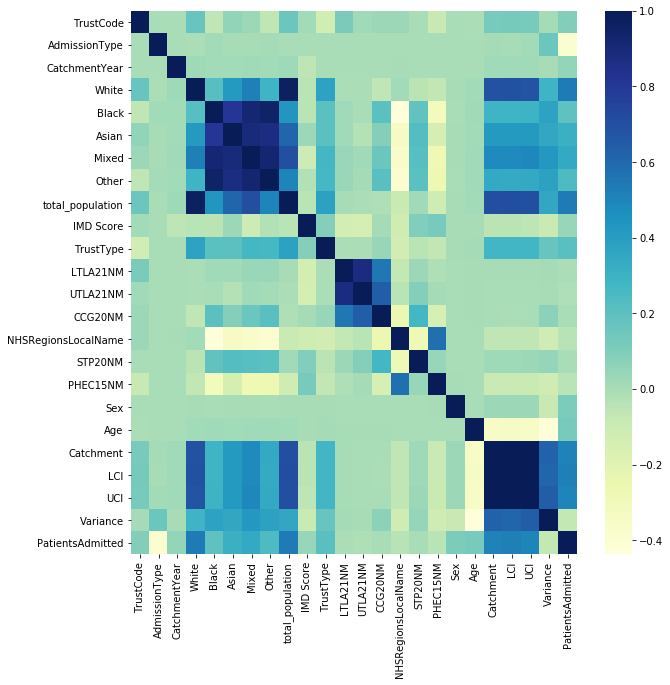

In [17]:
# By looking at the correlation among thses features in the thermal map.

# Divide the data columns into label columns and attribute columns
df_data_label = df_delnull_clean
de_label = df_delnull_clean['infect_pro']
del df_delnull_clean['infect_pro']

# get relevances
corr = df_delnull_clean.corr()
plt.figure(figsize=(10,10))
fig=sns.heatmap(corr,cmap="YlGnBu")
boxplot = fig.get_figure()

### Remove features with correlations greater than 0.9

In [18]:
name_ls = df_delnull_clean.columns.tolist()
corr_value = []
keep_col=[]
del_col = []
#select one of two columns who have correlations above 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                corr_value.append(corr.iloc[i,j])
                keep_col.append(name_ls[i])
                del_col.append(name_ls[j])
                
selected_columns = df_delnull_clean.columns[columns]
# The eigenvalues after dimensionality reduction, five were deleted
df_reduction = df_delnull_clean[selected_columns]


# Five indicators with correlation greater than 0.9 are displayed
corr_df = pd.DataFrame({'corr_value':corr_value,
                        'keep_col':keep_col,
                        'del_col':del_col})
print("Five indicators with correlation greater than 0.9 are displayed.\n",corr_df)
print("The original eigenvalues.\n",df_delnull_clean.shape)
print("The eigenvalues after dimensionality reduction, five were deleted.\n",df_reduction.shape)

Five indicators with correlation greater than 0.9 are displayed.
    corr_value   keep_col           del_col
0    0.969533      White  total_population
1    0.920097      Black             Mixed
2    0.950897      Black             Other
3    0.999861  Catchment               LCI
4    0.999869  Catchment               UCI
The original eigenvalues.
 (111584, 24)
The eigenvalues after dimensionality reduction, five were deleted.
 (111584, 19)


In [19]:
df_reduction

,TrustCode,AdmissionType,CatchmentYear,White,Black,Asian,IMD Score,TrustType,LTLA21NM,UTLA21NM,CCG20NM,NHSRegionsLocalName,STP20NM,PHEC15NM,Sex,Age,Catchment,Variance,PatientsAdmitted
0,0.0,0.0,2019.0,934841.0,15652.0,75765.0,26.741032,6.0,62.0,56.0,41.0,8.0,15.0,4.0,1.0,3.0,37571.0,103864.463376,6626.0
1,0.0,0.0,2019.0,934841.0,15652.0,75765.0,26.741032,6.0,62.0,56.0,41.0,8.0,15.0,4.0,1.0,6.0,38892.0,79660.548391,8224.0
2,0.0,0.0,2019.0,934841.0,15652.0,75765.0,26.741032,6.0,62.0,56.0,41.0,8.0,15.0,4.0,1.0,2.0,49191.0,128532.517581,8632.0
3,0.0,0.0,2019.0,934841.0,15652.0,75765.0,26.741032,6.0,62.0,56.0,41.0,8.0,15.0,4.0,1.0,4.0,45699.0,140938.743119,6872.0
4,0.0,0.0,2019.0,934841.0,15652.0,75765.0,26.741032,6.0,62.0,56.0,41.0,8.0,15.0,4.0,1.0,7.0,34441.0,62553.927012,8096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111579,141.0,2.0,2011.0,410692.0,4523.0,14301.0,17.028161,0.0,116.0,97.0,85.0,11.0,39.0,5.0,1.0,3.0,12868.0,47798.342947,1241.0
111580,141.0,2.0,2011.0,410692.0,4523.0,14301.0,17.028161,0.0,116.0,97.0,85.0,11.0,39.0,5.0,1.0,12.0,15178.0,20461.661734,2665.0
111581,141.0,2.0,2011.0,410692.0,4523.0,14301.0,17.028161,0.0,116.0,97.0,85.0,11.0,39.0,5.0,1.0,8.0,16046.0,41261.035397,1935.0
111582,141.0,2.0,2011.0,410692.0,4523.0,14301.0,17.028161,0.0,116.0,97.0,85.0,11.0,39.0,5.0,1.0,9.0,16599.0,42663.249405,2130.0


### Using Linear Regression to screen out features with significance greater than 0.05

In [21]:
data_ols.to_excel("../4_Output_tables/After_ols.xlsx",index = False)